In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext watermark
%watermark -ptorch,pandas,numpy -m

torch 0.4.1
pandas 0.22.0
numpy 1.15.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.10.0-32-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from pathlib import Path
import itertools
from functools import partial, reduce

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from fastai.text import (
    TextDataset, SortishSampler, SortSampler, DataLoader, ModelData, get_rnn_classifier, seq2seq_reg, 
    RNN_Learner, TextModel, to_gpu, LanguageModelLoader, LanguageModelData
)
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
path = Path("../data/cache/lm_douban/")
path.mkdir(parents=True, exist_ok=True)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Import And Tokenize Comments and Ratings

In [6]:
UNK = 2
BEG = 1

In [7]:
mapping = joblib.load("../data/mapping.pkl")
df_ratings = pd.read_csv("../data/ratings.csv")
df_ratings.head()

,comment,rating
0,别拿矫揉造作的资产阶级情调麻醉中国人民！,1
1,文青们向往的生活，可是生活中没有了喜怒哀乐，没有了问题与冲突，这种生活也只不过是看上去很美，...,2
2,自由也许在大理，生活确实在别处。,3
3,原来八旬是小四的老公，小彩旗的爹，杨丽萍的妹夫。,3
4,关于大理的蓝光旅游宣传片。,3


In [8]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=888)
train_idx, test_idx = next(sss.split(df_ratings, df_ratings.rating))
df_train = df_ratings.iloc[train_idx].copy()
df_test = df_ratings.iloc[test_idx].copy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=888)
val_idx, test_idx = next(sss.split(df_test, df_test.rating))
df_val = df_test.iloc[val_idx].copy()
df_test = df_test.iloc[test_idx].copy()
del df_ratings

In [9]:
df_test.iloc[0]["comment"],[mapping.get(x, 1) for x in df_test.iloc[0]["comment"]]

('无话可说.', [229, 689, 88, 252, 196])

In [10]:
results = []
tokens_train, tokens_val, tokens_test = [], [], []
for df, tokens in zip((df_train, df_val, df_test), (tokens_train, tokens_val, tokens_test)) :
    for i, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        tokens.append(np.array([BEG] + [mapping.get(x, UNK-1) + 1 for x in row["comment"]]))

In [11]:
assert len(tokens_train) == df_train.shape[0]

In [16]:
n_toks = max(mapping.values()) + 2 # starts with zero + the new BEG token
emb_dim = 300

### Prepare the embedding matrix

In [19]:
MODEL_PATH = "../data/cache/lm/models/lm_lstm.h5"
weights = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
weights['0.encoder.weight'].shape

torch.Size([3937, 300])

In [20]:
emb_dim = weights['0.encoder.weight'].shape[1]
new_weights = np.zeros((n_toks, weights['0.encoder.weight'].shape[1]))
new_weights[1:, :] = weights['0.encoder.weight']

In [21]:
assert np.array_equal(new_weights[2, :], weights['0.encoder.weight'][1, :])

In [13]:
weights['0.encoder.weight'] = T(new_weights)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_weights))
weights['1.decoder.weight'] = T(np.copy(new_weights))

## Languange Model

In [34]:
# reduce(lambda x, y: x + [BEG] + y, [["1", "2"], ["3", "4"]])

['1', '2', 1, '3', '4']

In [46]:
# reduce(lambda x, y: x + [BEG] + y, tokens_test[:2])

[230, 690, 89, 253, 197, 1, 603, 323, 1072, 366, 89, 490]

In [47]:
# def concatenate_tokens(tokens):
#     return reduce(lambda x, y: x + [BEG] + y, tokens)

In [14]:
bs = 64
bptt = 50
trn_dl = LanguageModelLoader(np.concatenate(tokens_train), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(tokens_val), bs, bptt)

In [15]:
from fastai.text import accuracy

In [19]:
model_data = LanguageModelData(path, 1, n_toks, trn_dl, val_dl, bs=bs, bptt=bptt)

In [23]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
opt_fn = partial(torch.optim.Adam, betas=(0.8, 0.99))

In [25]:
learner = model_data.get_model(opt_fn, emb_dim, 500, 3, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [26]:
learner.model.load_state_dict(weights)

In [28]:
lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=1e-7, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.596186   4.372825   0.246974  



[4.372824607216812, 0.24697363825823657]

In [29]:
learner.save('lm_last_ft')

In [35]:
learner.unfreeze()
learner.clip = 25
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.210581   4.020397   0.284001  



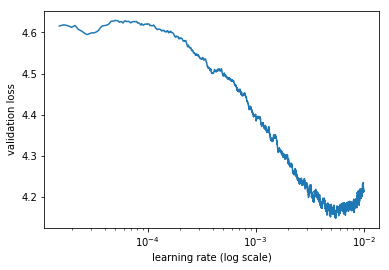

In [36]:
learner.sched.plot()

In [37]:
lr = 3e-3
lrs = lr
learner.fit(lrs, 1, wds=1e-7, use_clr=(20,5), cycle_len=10)

epoch      trn_loss   val_loss   accuracy                     
    0      4.105848   3.910348   0.298173  
    1      4.018932   3.820992   0.308487                     
    2      3.943559   3.762464   0.315814                     
    3      3.898625   3.72088    0.321251                     
    4      3.872065   3.692725   0.324847                     
    5      3.8252     3.665846   0.328488                     
    6      3.816848   3.64605    0.331198                     
    7      3.780636   3.628401   0.333646                     
    8      3.774507   3.613592   0.335545                     
    9      3.744667   3.604089   0.337058                     



[3.6040888550285866, 0.337058487797804]

In [39]:
learner.save_encoder("lm1_enc")

In [40]:
learner.save("lm1")

In [41]:
del learner

## 3-class Classifier
As in https://zhuanlan.zhihu.com/p/27198713

In [183]:
for df in (df_train, df_val, df_test):
    df["label"] = (df["rating"] >= 3) * 1
    df.loc[df.rating == 3, "label"] = 1
    df.loc[df.rating > 3, "label"] = 2

In [184]:
df_train.label.value_counts()

2    240094
1    184124
0    104406
Name: label, dtype: int64

In [186]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.label.values)
val_ds = TextDataset(tokens_val, df_val.label.values)
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [187]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [188]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=emb_dim, n_hid=500, n_layers=3, pad_token=0,
          layers=[emb_dim*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [189]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 82%|████████▏ | 13490/16520 [03:01<00:40, 74.21it/s, loss=3.55] 

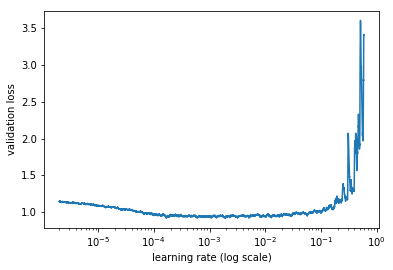

In [191]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [192]:
lr=2e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.9098     0.879256   0.577715  


[0.8792564643237936, 0.577714973213475]

In [193]:
learn.save('clas_0')

In [194]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.909985   0.859595   0.589911  


[0.8595946733215292, 0.5899107872514301]

In [195]:
learn.save('clas_1')

In [196]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                        
    0      0.86782    0.847476   0.597776  
    1      0.871917   0.824677   0.611913                        
    2      0.848754   0.812363   0.619864                        
    3      0.825071   0.803301   0.625051                        
    4      0.836958   0.798182   0.626884                        
    5      0.831828   0.794083   0.628933                        
    6      0.833921   0.791989   0.631487                        
    7      0.822722   0.789721   0.631816                        
    8      0.812759   0.784536   0.634392                        
    9      0.818841   0.785025   0.634012                        
    10     0.81486    0.780824   0.635641                        
    11     0.820534   0.782608   0.635794                        
    12     0.791192   0.781775   0.635953                        
    13     0.801983   0.781462   0.636106                        


[0.7814621505853775, 0.6361061926813766]

In [199]:
learn.save("clas_full")

### Evaluate

In [200]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm(val_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [201]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176208,), (176208,))

In [202]:
pd.Series(ys).value_counts()

2    80031
1    61374
0    34803
dtype: int64

In [203]:
pd.Series(preds).value_counts()

2    97582
1    46746
0    31880
dtype: int64

In [204]:
np.sum(ys==preds) / ys.shape[0]

0.6361061926813766

In [255]:
itos = ["pad", "BEG", "UNK"] + [0] *  n_toks
for k, v in mapping.items():
    itos[v+1] = k

In [256]:
np.where(ys==0)

(array([     8,     15,     22, ..., 176204, 176205, 176207]),)

In [264]:
"".join([itos[x] for x in tokens_val[176204]])

'BEG看了快一半了才发现是mini的广告'

In [242]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + [mapping.get(x, UNK-1) + 1 for x in texts])).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()

In [265]:
get_prediction("看了快一半了才发现是mini的广告")

array([[ 0.4 , -0.07, -1.36]], dtype=float32)

In [244]:
get_prediction("妈蛋，简直太好看了。最后的DJ battle部分，兴奋的我，简直想从座位上站起来一起扭")

array([[-1.96, -0.79,  3.19]], dtype=float32)

In [245]:
get_prediction("说实话我没怎么认真看，电影院里的熊孩子太闹腾了，前面的小奶娃还时不时站在老爸腿上蹦迪，观影体验极差，不过小朋友应该挺喜欢的")

array([[-0.87,  0.53, -0.31]], dtype=float32)

In [247]:
get_prediction("这电影太好笑了，说好的高科技人才研制的产品永远在关键时候失灵；特地飞到泰国请来救援人才，大家研究出的方法每次都是先给鲨鱼当诱饵……显然这样的对战坚持不了多久，只能赶紧让鲨鱼输了。")

array([[-1.8 , -0.11,  1.54]], dtype=float32)

In [248]:
get_prediction("太接地气了，在三亚煮饺子式的景区海域，冒出来一条大鲨鱼……爽点也很密集，郭达森与李冰冰的CP感不错，编剧果然是老外，中文台词有点尬。")

array([[-1.4 ,  0.39,  0.25]], dtype=float32)

In [249]:
get_prediction("李冰冰的脸真的很紧绷，比鲨鱼的脸还绷。")

array([[-0.17,  0.56,  0.17]], dtype=float32)

In [266]:
get_prediction("太难了。。。")

array([[ 0.19, -0.09, -0.06]], dtype=float32)

In [267]:
get_prediction("把我基神写成智障，辣鸡mcu")

array([[ 0.67, -0.26, -0.15]], dtype=float32)

In [250]:
get_prediction("鲨鱼部分还是不错的，尤其是中段第一次出海捕鲨非常刺激，其后急速下滑，三亚那部分拍得是什么鬼。。。爆米花片可以适度的蠢，但人类反派炸鲨和直升机相撞部分简直蠢得太过份了吧？另外充满硬加戏视感的尴尬感情戏把节奏也拖垮了，明明可以更出色，却很遗憾地止步在马马虎虎的水平。6/10")

array([[-1.69,  0.94, -1.89]], dtype=float32)

In [251]:
get_prediction("老冰冰真的很努力！为老冰冰实现了她的好莱坞女主梦鼓掌...")

array([[-1.62,  0.32,  1.31]], dtype=float32)

In [252]:
get_prediction("结局简直丧出天际！灭霸竟然有内心戏！全程下来美队和钢铁侠也没见上一面，我还以为在世界末日前必然要重修旧好了！")

array([[-0.46, -0.12,  0.1 ]], dtype=float32)

In [268]:
get_prediction("太烂了，难看至极。")

array([[ 7.99, -0.57, -3.55]], dtype=float32)

In [270]:
get_prediction("看完之后很生气！剧情太差了")

array([[ 1.67,  0.07, -1.12]], dtype=float32)

In [272]:
get_prediction("关键点都好傻，我知道你要拍续集，我知道未来可以被重写， 但那一拳真的有点傻。")

array([[ 0.53,  0.11, -0.43]], dtype=float32)

In [273]:
get_prediction("好了可以了。再也不看Marvel了。我努力过了。实在是。。啥呀这是。🙄️")

array([[ 0.01,  0.12, -0.08]], dtype=float32)

In [274]:
get_prediction("还我电影票14元")

array([[ 1.15, -0.65, -1.04]], dtype=float32)

Confusion matrix, without normalization
[[20007  8784  6012]
 [ 8630 26627 26117]
 [ 3243 11335 65453]]


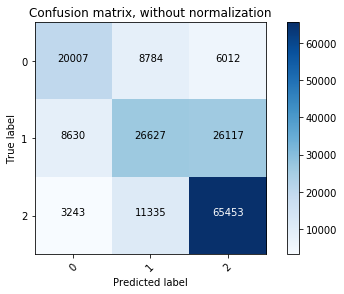

In [231]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.57 0.25 0.17]
 [0.14 0.43 0.43]
 [0.04 0.14 0.82]]


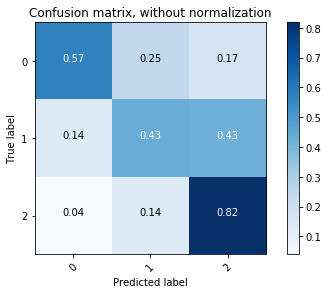

In [232]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [107]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 64%, R 55%, FS 0.59, Support: 34803
Class 1: P 55%, R 49%, FS 0.52, Support: 61374
Class 2: P 69%, R 78%, FS 0.73, Support: 80031


In [112]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [113]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [115]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [116]:
np.sum(ys==preds) / ys.shape[0]

0.6169945916496887

Confusion matrix, without normalization
[[21139  6275  7388]
 [11345 20429 29601]
 [ 4565  8315 67152]]


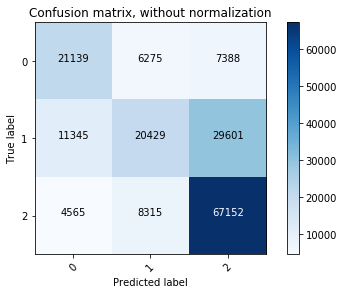

In [117]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.61 0.18 0.21]
 [0.18 0.33 0.48]
 [0.06 0.1  0.84]]


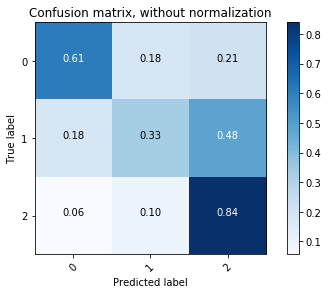

In [118]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [119]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 57%, R 61%, FS 0.59, Support: 34802
Class 1: P 58%, R 33%, FS 0.42, Support: 61375
Class 2: P 64%, R 84%, FS 0.73, Support: 80032


### Smaller Dataset 

In [131]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [162]:
df_train_small = pd.concat([
    df_train[df_train.label==0].sample(15000),
    df_train[df_train.label==1].sample(15000),
    df_train[df_train.label==2].sample(15000)
], axis=0)
df_val_small = pd.concat([
    df_val[df_val.label==0].sample(5000),
    df_val[df_val.label==1].sample(5000),
    df_val[df_val.label==2].sample(5000)
], axis=0)

In [163]:
np.array(df_train_small.index)

array([392726, 438176,  31056, ...,   7144, 188177, 452052])

In [164]:
bs = 64
tokens_train_small = np.array(tokens_train)[np.array(df_train_small.index)]
tokens_val_small = np.array(tokens_val)[np.array(df_val_small.index)]
trn_ds = TextDataset(tokens_train_small, df_train_small.label.values)
val_ds = TextDataset(tokens_val_small, df_val_small.label.values)
trn_samp = SortishSampler(tokens_train_small, key=lambda x: len(tokens_train_small[x]), bs=bs//2)
val_samp = SortSampler(tokens_val_small, key=lambda x: len(tokens_val_small[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [165]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [166]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=emb_dim, n_hid=500, n_layers=3, pad_token=0,
          layers=[emb_dim*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [167]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 79%|███████▉  | 1110/1407 [00:12<00:03, 88.30it/s, loss=2.28]

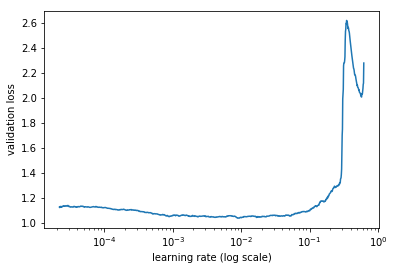

In [168]:
learn.freeze_to(-1)
learn.lr_find(lrs/100)
learn.sched.plot()

In [169]:
lr=2e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.035968   0.954733   0.534467  


[0.9547327213923137, 0.5344666666825613]

In [170]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.011529   0.931103   0.546867  


[0.9311027950922648, 0.5468666666825612]

In [171]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      1.012176   0.923007   0.550333  
    1      0.991352   0.906067   0.560933                      
    2      0.983911   0.893279   0.568267                      
    3      0.942371   0.882986   0.5756                        
    4      0.944522   0.879921   0.5816                        
    5      0.937489   0.8825     0.576733                      
    6      0.913783   0.873022   0.5856                        
    7      0.934132   0.871516   0.582667                      
    8      0.937716   0.870473   0.587267                      
    9      0.929128   0.871219   0.587867                      
    10     0.911203   0.859746   0.590667                      
    11     0.930146   0.86444    0.590333                      
    12     0.888316   0.869584   0.590733                      
    13     0.932057   0.86972    0.587467                      


[0.8697198063850403, 0.5874666666666667]

In [172]:
learn.save("clas_small_full")

In [173]:
learn.model.eval()
preds, ys = [], []
for x, y in val_dl:
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [174]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((15000,), (15000,))

Normalized confusion matrix
[[0.64 0.21 0.15]
 [0.23 0.39 0.38]
 [0.09 0.18 0.73]]


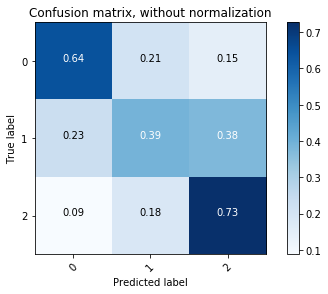

In [176]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [177]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [178]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [179]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [182]:
np.sum(preds==ys) / preds.shape[0]

0.5955257676963152

Normalized confusion matrix
[[0.63 0.21 0.16]
 [0.23 0.4  0.37]
 [0.09 0.18 0.73]]


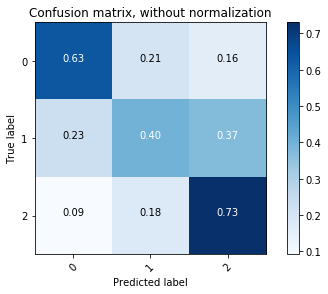

In [180]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [181]:
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 51%, R 63%, FS 0.56, Support: 34802
Class 1: P 53%, R 40%, FS 0.46, Support: 61375
Class 2: P 67%, R 73%, FS 0.70, Support: 80032


## Regressor

In [13]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.rating.values.astype("float32"))
val_ds = TextDataset(tokens_val, df_val.rating.values.astype("float32"))
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [14]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [17]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=emb_dim, n_hid=500, n_layers=3, pad_token=0,
          layers=[emb_dim*3, 50, 1], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [19]:
class RNN_RegLearner(RNN_Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return lambda x, y: F.mse_loss(x[:, 0], y)

In [20]:
learn = RNN_RegLearner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = []
learn.load_encoder('lm1_enc')

In [38]:
lr=2e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

 81%|████████  | 13342/16520 [02:44<00:39, 81.01it/s, loss=1.63] 

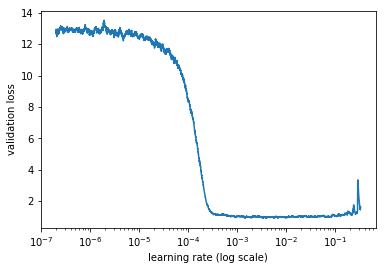

In [39]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [40]:
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_0')

epoch      trn_loss   val_loss                                   
    0      0.996772   0.862563  


In [41]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_1')

epoch      trn_loss   val_loss                                   
    0      0.910084   0.838062  


In [42]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))
learn.save('reg_full')

epoch      trn_loss   val_loss                                   
    0      0.925085   0.825708  
    1      0.881804   0.780538                                   
    2      0.843841   0.745593                                   
    3      0.784886   0.739938                                   
    4      0.796248   0.73093                                    
    5      0.788244   0.721178                                   
    6      0.791241   0.730937                                   
    7      0.740036   0.708046                                   
    8      0.736218   0.706417                                   
    9      0.791063   0.703033                                   
    10     0.778644   0.715297                                   
    11     0.744331   0.713795                                   
    12     0.756549   0.694932                                   
    13     0.748097   0.699994                                   


In [83]:
# Export Model
torch.save(learn.model, path / "sentiment_model.pth")

In [21]:
learn.load('reg_full')

### Evaluation

In [23]:
test_ds = TextDataset(tokens_test, df_test.rating.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [63]:
def get_preds(data_loader):
    learn.model.eval()
    learn.model.reset()         
    preds, ys = [], []
    for x, y in tqdm_notebook(data_loader):   
        preds.append(learn.model(x)[0].cpu().data.numpy()[:, 0])
        ys.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    ys = np.concatenate(ys)
    return ys, preds
ys, preds = get_preds(val_dl)
preds.shape, ys.shape

((176208,), (176208,))

In [32]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [33]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [67]:
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6999935800304186

In [68]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6948152183782802

In [71]:
# Save predictions
df_val.loc[df_val.iloc[list(iter(val_samp))].index, "preds"] = preds
df_val.to_csv(path / "df_val.csv.gz", index=False, compression="gzip")
df_val.head()

,comment,rating,preds
681247,男主角像卡卡,2,3.465383
665056,经典改编，还是忠于原著的，一路都很稳。,4,3.863266
76994,叙事：时间空间的有机结合,5,3.738311
801291,看街头小混混打外星人挺热闹的，可是前一秒还在抢劫的少年犯，下一秒就变成了拯救世界的大英雄，导...,2,2.558038
460388,这电影也就一般,3,2.455681


In [72]:
np.sum(np.square(df_val.rating.values - df_val.preds.values)) / preds.shape[0]

0.694815236118216

In [73]:
ys, preds = get_preds(test_dl)
preds.shape, ys.shape

((176209,), (176209,))

In [74]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.7007709156019223

In [75]:
# Save predictions
df_test.loc[df_test.iloc[list(iter(test_samp))].index, "preds"] = preds
df_test.to_csv(path / "df_test.csv.gz", index=False, compression="gzip")
df_test.head()

,comment,rating,preds
258461,无话可说.,3,2.588530
118491,老师你太可爱,5,4.113175
44768,说了好多话，可惜都是陈词滥调、无凭无据。,2,2.549929
34630,普巴家用的电脑是苹果。,3,3.019567
382761,这才是一部看完之后观众讲不清道不明的电影，主线不明了，支线都快抢过主线的风头了。而且，我也讲...,4,3.420727


In [81]:
df_test.sample(20)

,comment,rating,preds
789220,这个系列有点莫名其妙,3,2.801186
213152,一部充满生命力的纪录片雨果跟妈妈的相处模式太感人,4,4.529860
739042,初中看的，当时还觉得挺吓人的,2,3.378826
12267,十年后就会是个大笑话，除非某人2b了,5,3.238261
332363,老特工得了绝症，希望能更多的陪老婆孩子，接受最后一个任务，以此获得治疗和高额报酬。大团圆结局。,3,3.680141
24966,看似小人物的淡淡描述，却反映了城市的变迁和现实的问题，还看到了一群即使不如意也从不放弃以个人...,4,4.351521
765324,其实杀阵我是可以接受的可是鼎鼎大名的无限之住人还是在情节的衔接上面出了很多无法驾驭文戏的问题...,3,3.163257
861936,挺好，虽无亮点，但我天朝拍就毁了。这个翻拍史密斯夫妇竟然木有授权？,3,3.161193
389113,警察小哥升官发财泡美女，最后才看出来原来是颜色革命的埃及版。,3,3.513502
24493,日语听懂了不到1%，长泽还是短发转折后比较有特色，日本人真心向往米国啊.。,3,3.509034


In [76]:
np.sum(np.square(df_test.rating.values - df_test.preds.values)) / preds.shape[0]

0.7007709156019224

In [77]:
preds_class = np.round(preds)

Confusion matrix, without normalization
[[ 2210  4255  4059   940    58]
 [  941  7091 12532  2679    37]
 [  184  4407 35508 20897   379]
 [   23   630 15650 36027  2319]
 [   15   211  3782 17525  3850]]


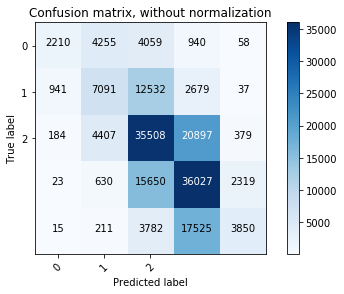

In [78]:
cnf_matrix = confusion_matrix(ys, preds_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

In [79]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds_class)
for i in range(5):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 66%, R 19%, FS 0.30, Support: 11522
Class 1: P 43%, R 30%, FS 0.36, Support: 23280
Class 2: P 50%, R 58%, FS 0.53, Support: 61375
Class 3: P 46%, R 66%, FS 0.54, Support: 54649
Class 4: P 58%, R 15%, FS 0.24, Support: 25383


In [66]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + [mapping.get(x, UNK-1) + 1 for x in texts])).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()[0, 0]

In [67]:
get_prediction("看了快一半了才发现是mini的广告")

2.3815765

In [68]:
get_prediction("妈蛋，简直太好看了。最后的DJ battle部分，兴奋的我，简直想从座位上站起来一起扭")

4.897096

In [69]:
get_prediction("说实话我没怎么认真看，电影院里的熊孩子太闹腾了，前面的小奶娃还时不时站在老爸腿上蹦迪，观影体验极差，不过小朋友应该挺喜欢的")

3.0604544

In [70]:
get_prediction("李冰冰的脸真的很紧绷，比鲨鱼的脸还绷。")

3.063489

In [71]:
get_prediction("太烂了，难看至极。")

0.9119679

In [72]:
get_prediction("还我电影票14元")

1.9868466

In [73]:
get_prediction("好了可以了。再也不看Marvel了。我努力过了。实在是。。啥呀这是。🙄️")

3.0860696

In [74]:
get_prediction("把我基神写成智障，辣鸡mcu")

2.3895512